# Feature Selection Example

## Imports

In [1]:
import numpy as np
from sklearn.feature_selection import (
    SelectKBest, chi2, f_classif,
    mutual_info_classif, RFE,
    SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Feature Selector Class

In [2]:
class FeatureSelector:
    """
    Comprehensive feature selection toolkit
    """
    
    def __init__(self):
        self.selected_features = None
        self.feature_scores = None
    
    def filter_method(self, X, y, method='chi2', k=10):
        """
        Filter-based feature selection
        
        Args:
            X: Feature matrix
            y: Target labels
            method: 'chi2', 'f_classif', or 'mutual_info'
            k: Number of features to select
        """
        if method == 'chi2':
            selector = SelectKBest(chi2, k=k)
        elif method == 'f_classif':
            selector = SelectKBest(f_classif, k=k)
        elif method == 'mutual_info':
            selector = SelectKBest(mutual_info_classif, k=k)
        else:
            raise ValueError(f"Unknown method: {method}")
        
        X_selected = selector.fit_transform(X, y)
        self.selected_features = selector.get_support()
        self.feature_scores = selector.scores_
        
        return X_selected, self.selected_features
    
    def wrapper_method(self, X, y, estimator=None, n_features=10):
        """
        Wrapper-based feature selection using RFE
        """
        if estimator is None:
            estimator = RandomForestClassifier(n_estimators=50)
        
        selector = RFE(estimator, n_features_to_select=n_features)
        X_selected = selector.fit_transform(X, y)
        
        self.selected_features = selector.support_
        self.feature_scores = selector.ranking_
        
        return X_selected, self.selected_features
    
    def embedded_method(self, X, y, method='lasso', threshold='mean'):
        """
        Embedded feature selection
        """
        if method == 'lasso':
            estimator = LinearSVC(C=0.01, penalty="l1", dual=False)
        elif method == 'tree':
            estimator = RandomForestClassifier(n_estimators=100)
        else:
            raise ValueError(f"Unknown method: {method}")
        
        selector = SelectFromModel(estimator, threshold=threshold)
        X_selected = selector.fit_transform(X, y)
        
        self.selected_features = selector.get_support()
        
        # Get feature importances if available
        if hasattr(selector.estimator_, 'feature_importances_'):
            self.feature_scores = selector.estimator_.feature_importances_
        elif hasattr(selector.estimator_, 'coef_'):
            self.feature_scores = np.abs(selector.estimator_.coef_).mean(axis=0)
        
        return X_selected, self.selected_features
    
    def visualize_selection(self, feature_names=None):
        """
        Visualize selected features and their scores
        """
        if self.feature_scores is None:
            print("No feature scores available")
            return
        
        n_features = len(self.feature_scores)
        
        if feature_names is None:
            feature_names = [f'F{i}' for i in range(n_features)]
        
        # Sort features by score
        sorted_idx = np.argsort(self.feature_scores)[::-1]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Bar plot of feature scores
        colors = ['green' if self.selected_features[i] else 'red' 
                 for i in sorted_idx[:20]]
        
        ax1.barh(range(min(20, n_features)), 
                self.feature_scores[sorted_idx[:20]], 
                color=colors)
        ax1.set_yticks(range(min(20, n_features)))
        ax1.set_yticklabels([feature_names[i] for i in sorted_idx[:20]])
        ax1.set_xlabel('Feature Score')
        ax1.set_title('Top 20 Features (Green=Selected, Red=Not Selected)')
        ax1.invert_yaxis()
        
        # Selected vs not selected distribution
        selected_scores = self.feature_scores[self.selected_features]
        not_selected_scores = self.feature_scores[~self.selected_features]
        
        ax2.hist([selected_scores, not_selected_scores], 
                label=['Selected', 'Not Selected'],
                alpha=0.7, bins=20)
        ax2.set_xlabel('Feature Score')
        ax2.set_ylabel('Count')
        ax2.set_title('Score Distribution')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    def compare_methods(self, X, y, feature_names=None):
        """
        Compare different feature selection methods
        """
        methods = {
            'Chi-square': lambda: self.filter_method(X, y, 'chi2', k=10),
            'F-score': lambda: self.filter_method(X, y, 'f_classif', k=10),
            'RFE': lambda: self.wrapper_method(X, y, n_features=10),
            'Lasso': lambda: self.embedded_method(X, y, 'lasso')
        }
        
        results = {}
        
        for name, method in methods.items():
            X_selected, features = method()
            results[name] = {
                'selected': features,
                'n_features': features.sum(),
                'scores': self.feature_scores.copy() if self.feature_scores is not None else None
            }
        
        # Visualize comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()
        
        for idx, (name, result) in enumerate(results.items()):
            ax = axes[idx]
            
            if result['scores'] is not None:
                # Create a binary mask for coloring
                colors = ['green' if f else 'red' for f in result['selected']]
                
                # Plot feature scores
                ax.bar(range(len(result['scores'])), result['scores'], 
                      color=colors, alpha=0.7)
                ax.set_title(f'{name} (Selected: {result["n_features"]})')
                ax.set_xlabel('Feature Index')
                ax.set_ylabel('Score')
            else:
                ax.text(0.5, 0.5, f'{name}\n{result["n_features"]} features selected',
                       ha='center', va='center', fontsize=14)
                ax.axis('off')
        
        plt.suptitle('Feature Selection Method Comparison', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        return results

## Main

In [7]:
# Demonstrate feature selection on image features
def feature_selection_demo():
    """
    Demonstrate feature selection on combined image features
    """
    # Generate synthetic feature data
    np.random.seed(42)
    n_samples = 1000
    n_features = 50
    n_informative = 15
    
    # Create features: some informative, some noise
    # IMPORTANT: Make all features non-negative for chi2 compatibility
    X_informative = np.abs(np.random.randn(n_samples, n_informative)) + 0.5
    X_noise = np.abs(np.random.randn(n_samples, n_features - n_informative) * 0.5)
    X = np.hstack([X_informative, X_noise])
    
    # Ensure all values are non-negative (add small constant to avoid zeros)
    X = np.abs(X) + 0.01
    
    # Create labels based on informative features
    # Use median as threshold to ensure balanced classes
    feature_sum = X[:, :5].sum(axis=1) + X[:, 10:12].sum(axis=1)
    threshold = np.median(feature_sum)
    y = (feature_sum > threshold).astype(int)
    
    # Verify class distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f"Class distribution: {dict(zip(unique, counts))}")
    
    # Feature names (simulating different feature types)
    feature_names = (
        [f'HOG_{i}' for i in range(20)] +
        [f'LBP_{i}' for i in range(15)] +
        [f'GLCM_{i}' for i in range(10)] +
        [f'Color_{i}' for i in range(5)]
    )
    
    # Initialize selector
    selector = FeatureSelector()
    
    # Compare methods
    print("Comparing Feature Selection Methods")
    print("=" * 50)
    results = selector.compare_methods(X, y, feature_names)
    
    # Show which features were consistently selected
    print("\nFeature Selection Consensus:")
    print("-" * 30)
    
    consensus = np.zeros(n_features)
    for name, result in results.items():
        if result['selected'] is not None:
            consensus += result['selected'].astype(int)
    
    # Features selected by multiple methods
    threshold = len(results) // 2
    consensus_features = consensus >= threshold
    
    print(f"Features selected by {threshold}+ methods:")
    for i, selected in enumerate(consensus_features):
        if selected:
            print(f"  {feature_names[i]}: selected by {int(consensus[i])} methods")
    
    return results

Class distribution: {0: 500, 1: 500}
Comparing Feature Selection Methods


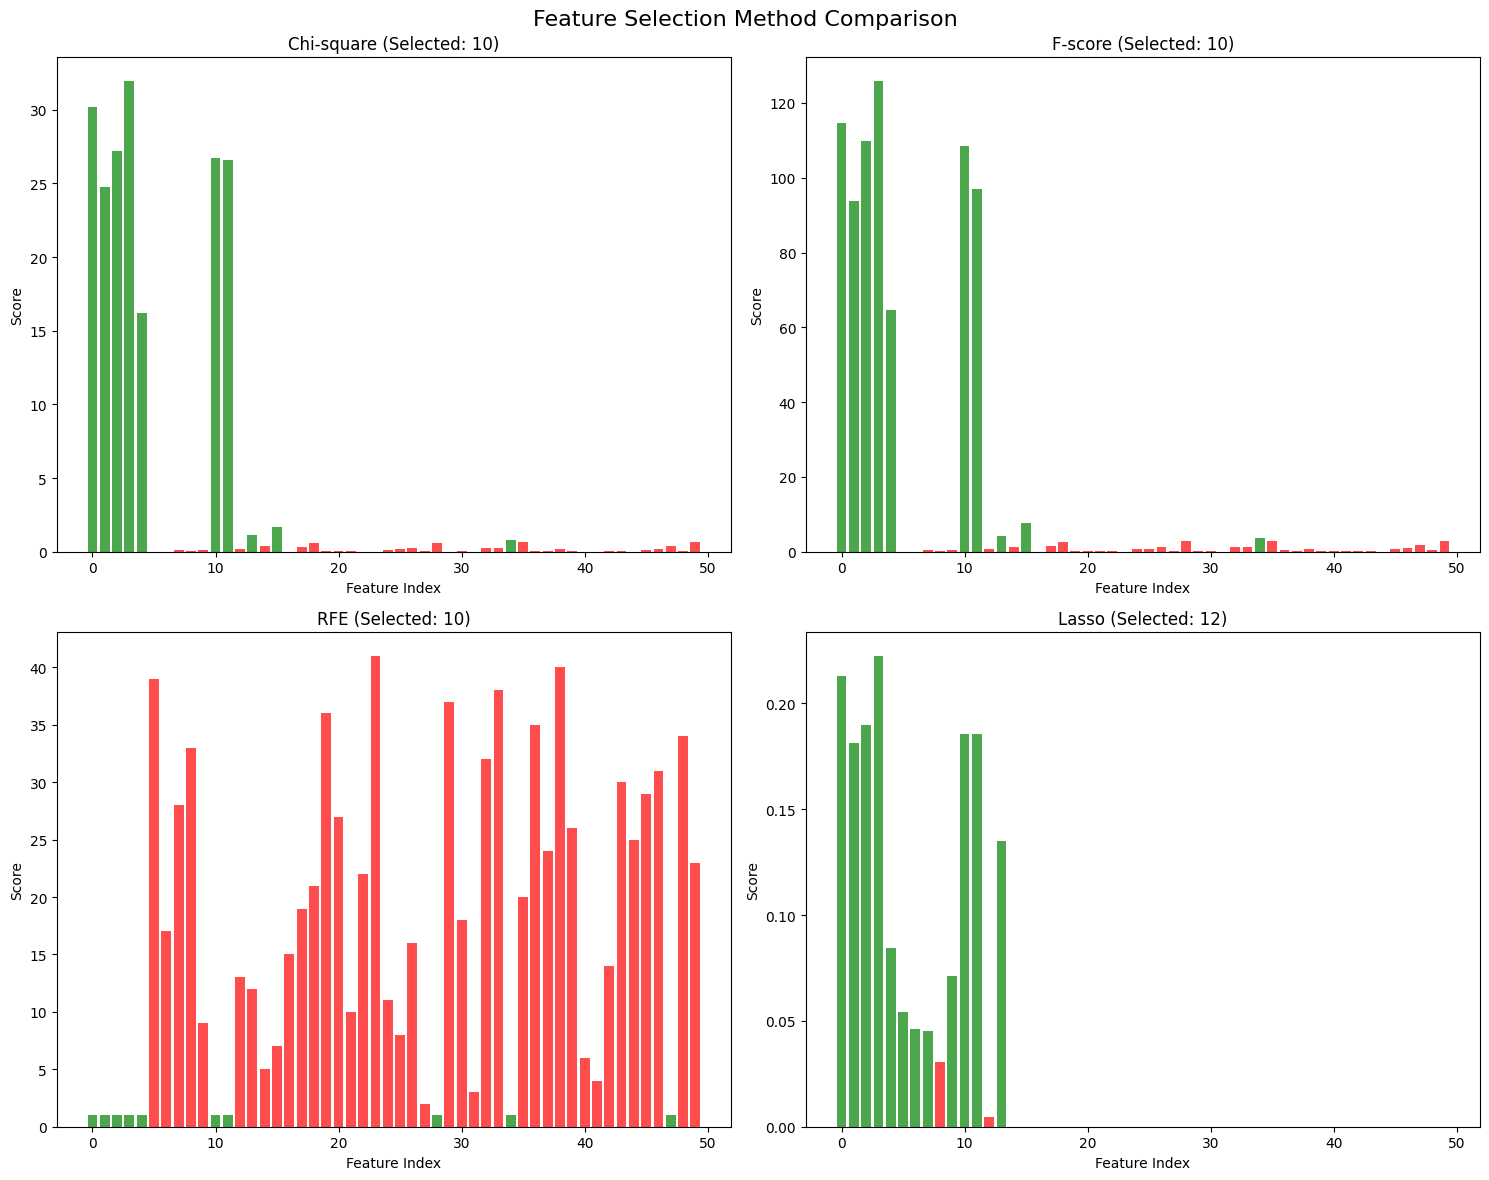


Feature Selection Consensus:
------------------------------
Features selected by 2+ methods:
  HOG_0: selected by 4 methods
  HOG_1: selected by 4 methods
  HOG_2: selected by 4 methods
  HOG_3: selected by 4 methods
  HOG_4: selected by 4 methods
  HOG_10: selected by 4 methods
  HOG_11: selected by 4 methods
  HOG_13: selected by 3 methods
  HOG_15: selected by 2 methods
  LBP_14: selected by 3 methods


In [8]:
# Run the demonstration
results = feature_selection_demo()